<a href="https://colab.research.google.com/github/samiha-mahin/An-Image-Processing-Repo/blob/main/Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # Upload your kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"3b6d29c9556db74812f31ee98a90662f"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset -p ./data --unzip


Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 78% 152M/195M [00:00<00:00, 560MB/s] 
100% 195M/195M [00:00<00:00, 492MB/s]


In [5]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization,
                                     GlobalAveragePooling2D, GaussianNoise, MultiHeadAttention)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

sns.set_style("whitegrid")


# **Load Dataset into DataFrame**

In [27]:
import numpy as np
import pandas as pd
import os
import cv2

In [28]:
base_path = "./data/Dataset_BUSI_with_GT"

categories = ["benign","malignant","normal"]

data = []

for label in categories:
    folder = os.path.join(base_path, label)
    for file in os.listdir(folder):
      if file.endswith(".png") and "_mask" not in file:
        data.append([os.path.join(folder,file),label])

df = pd.DataFrame(data, columns=["image_path","label"])
print("Dataset Shape:",df.shape)
df.head()

Dataset Shape: (780, 2)


,image_path,label
0,./data/Dataset_BUSI_with_GT/benign/benign (372...,benign
1,./data/Dataset_BUSI_with_GT/benign/benign (75)...,benign
2,./data/Dataset_BUSI_with_GT/benign/benign (306...,benign
3,./data/Dataset_BUSI_with_GT/benign/benign (188...,benign
4,./data/Dataset_BUSI_with_GT/benign/benign (14)...,benign


### Code Explaination:

1. **Set the dataset location** → `base_path`
   (where the images are stored).

2. **Define categories** → `benign`, `malignant`, `normal`.
   (these are the folders inside `base_path`).

3. **Loop through each category**

   * Go inside the folder.
   * Look at all image files (`.png`).
   * Skip files that have `_mask` in their name (because those are segmentation masks, not raw images).

4. **Save info into a list** → each image gets stored with its path and label.

5. **Convert list into a DataFrame (df)** → easy to use later for ML.

6. **Print dataset shape and preview**



#**Visualize Data Distribution**

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipython-input-3309689242.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df ,palette='pastel')


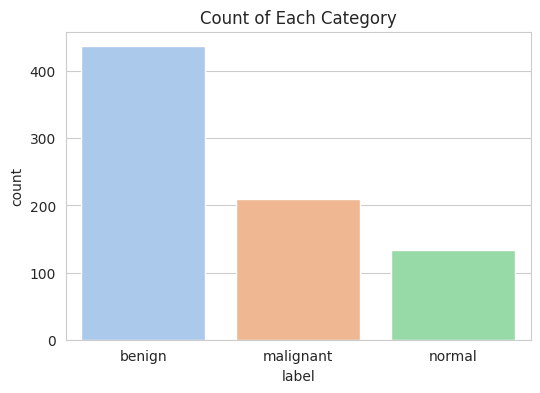

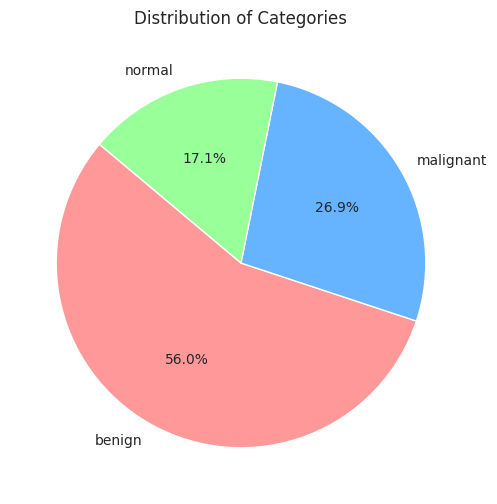

In [30]:
# Bar chart of categories
plt.figure(figsize=(6, 4))
sns.countplot(x="label", data=df ,palette='pastel')
plt.title("Count of Each Category")
plt.show()

# Pie chart of categories
df["label"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", startangle=140, figsize=(6, 6),colors=['#ff9999','#66b3ff','#99ff99']
)
plt.title("Distribution of Categories")
plt.ylabel("")  # removes y-axis label
plt.show()


# **Encode Labels & Balance Dataset**

In [32]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

In [33]:
#Encoding the labels into the numbers
encoder = LabelEncoder()
df["Label_num"] = encoder.fit_transform(df["label"])

#Oversample to balance classes
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(df[["image_path"]], df["Label_num"])

#Creating the new balanced dataFrame
df_balanced = pd.DataFrame({"image_path":X["image_path"] , "label_num":y})

print("\nBalanced class counts:")
print(df_balanced["label_num"].value_counts())


Balanced class counts:
label_num
0    437
1    437
2    437
Name: count, dtype: int64


# **Train/Valid/Test Split**

In [34]:
from sklearn.model_selection import train_test_split

In [40]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str) #the category 1, 2, 3 will become string like "1","2","3"

train_df, temp_df = train_test_split(df_resampled, train_size=0.8, shuffle=True,
                                     stratify=df_resampled['category_encoded'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True,
                                     stratify=temp_df['category_encoded'], random_state=42)

print("Train size:", train_df.shape)
print("Validation size:", valid_df.shape)
print("Test size:", test_df.shape)

Train size: (1048, 2)
Validation size: (131, 2)
Test size: (132, 2)


# **Data Generators**

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image_path', y_col='category_encoded',
                                       target_size=img_size, class_mode='sparse',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image_path', y_col='category_encoded',
                                       target_size=img_size, class_mode='sparse',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image_path', y_col='category_encoded',
                                      target_size=img_size, class_mode='sparse',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 1048 validated image filenames belonging to 3 classes.
Found 131 validated image filenames belonging to 3 classes.
Found 132 validated image filenames belonging to 3 classes.


# **Build Transfer Learning Model (VGG16 + Attention)**

In [48]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GaussianNoise, MultiHeadAttention
from tensorflow.keras.optimizers import Adam

def create_model(input_shape=(224, 224, 3), num_classes=3):
    # Input
    inputs = Input(shape=input_shape)

    # Pretrained VGG16 (without top layers)
    base = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    # Freeze all layers except last 4
    for layer in base.layers[:-4]:
        layer.trainable = False

    x = base.output

    # Add attention and noise
    x = MultiHeadAttention(num_heads=8, key_dim=x.shape[-1])(x, x)
    x = GaussianNoise(0.25)(x)

    # Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Create model
model = create_model()

# Compile model
model.compile(optimizer=Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_4[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 23,512,899 (89.69 MB)

 Trainable params: 15,876,611 (60.56 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

### **VGG16-based model explanation**

| Step | Code / Layer                                   | What It Does                                                | Purpose                                                |
| ---- | ---------------------------------------------- | ----------------------------------------------------------- | ------------------------------------------------------ |
| 1    | `Input(shape=(224,224,3))`                     | Takes image input                                           | Sets input size for the model                          |
| 2    | `VGG16(weights='imagenet', include_top=False)` | Pretrained VGG16 without top layers                         | Uses learned features from ImageNet                    |
| 3    | `layer.trainable = False` (for most layers)    | Freeze most layers                                          | Prevents unnecessary changes; only last 4 layers train |
| 4    | `MultiHeadAttention` + `GaussianNoise`         | Attention focuses on important parts; noise adds randomness | Helps the model focus and generalize                   |
| 5    | `GlobalAveragePooling2D`                       | Converts 3D feature maps to 1D vector                       | Prepares features for dense layers                     |
| 6    | `Dense + BatchNorm + Dropout`                  | Fully connected layers with normalization and dropout       | Learn patterns and prevent overfitting                 |
| 7    | `Dense(3, activation='softmax')`               | Output layer                                                | Predicts 3 classes with probabilities                  |
| 8    | `model.compile(...)`                           | Sets optimizer, loss, metrics                               | Prepares model for training                            |
| 9    | `model.summary()`                              | Shows layer details                                         | Visualize model structure                              |


# **Train Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=15,
                    callbacks=[early_stopping],
                    verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 2/66 ━━━━━━━━━━━━━━━━━━━━ 14:44 14s/step - accuracy: 0.3125 - loss: 1.2585